# Graph attention networks and molecular applications 

Attention mechanism revisits us. <br>
In natural language processing, the attention mechanisms - local and global - find the relationship between the words and give scores. 

We can apply the attention in graph convolution network as well. <br>
A node embedding in GCN is 

$$ H_i^{(l)} = \sigma( \sum_{j \in N(i)} H_j^{(l)}W^{(l)} )$$

GCN considers the adjacent nodes and itself with equal weights in updating node states.<br>
However, it is more natural that the importance of each node is different, and the importance can be obtained by learning the relationship between node states.

With attention coefficient, the node embedding can be rewritten as follow.

$$ H_i^{(l+1)} = \sigma( \sum_{j \in N(i)} \alpha_{ij}^{(l)} H_j^{(l)}W^{(l)} ) $$
$$ \alpha_{ij}^{(l)} = f(H_i^{(l)}W^{(l)}, H_j^{(l)}W^{(l)}) $$

There are various approaches to obtain the attention coefficient, $\alpha_{ij}$, and three approaches are introduced in the following reference: 
* Luong, Minh-Thang, Hieu Pham, and Christopher D. Manning. "Effective approaches to attention-based neural machine translation." arXiv preprint arXiv:1508.04025 (2015).

In the paper "Graph attention networks", authors represent the attention coefficient by concatenation. 
* Velickovic, Petar, et al. "Graph attention networks." arXiv preprint arXiv:1710.10903 (2017).

$$ \alpha_{ij} = softmax(e_{ij}) = \frac{e_{ij}}{\sum_{k \in N(i)} e_{ik}} $$
$$ e_{ij} = f(H_iW, H_jW) = \tau(a^T (H_iW||H_jW))$$

Normalizing the coefficient with softmax activation isn't proper for molecular applications, however, we recommend $e_{ij}$ term only for the case. <br>
We use a general form of the attention in our works which investigate molecular structure property relationship using the graph attention network.
* Ryu, Seongok, Jaechang Lim, and Woo Youn Kim. "Deeply learning molecular structure-property relationships using graph attention neural network." arXiv preprint arXiv:1805.10988 (2018).

$$ \alpha_{ij} = \sigma((H_iW)C(H_jW)^T) $$

The concatenation method needs $2F$ number of paramters need to be trained, however, our one needs $F^2$.
If F is larger than 2, the former one is more efficient. The feature dimensions in our applications are not large, however, it was okay to use later one. 

In addition, we can use multiple times of the attention mechanism in single node updating - so called multi-head attention. <br>
Two ways are introduced in the original GAT paper, one represents by average of all attention channels.

$$ H_i^{(l)} = \sigma( \frac{1}{K} \sum_{k=1}^{K} \sum_{j \in N(i)} \alpha_{ij,k}^{(l)}H_j^{(l)}W_k^{(l)} ) $$

and the other by concatenation of channels.

$$ H_i^{(l)} = ||_{k=1}^K \sigma( \sum_{j \in N(i)} \alpha_{ij,k}^{(l)}H_j^{(l)}W_k^{(l)} ) $$

In summary, schematic desription is shown in below figure.

/Users/Lulu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


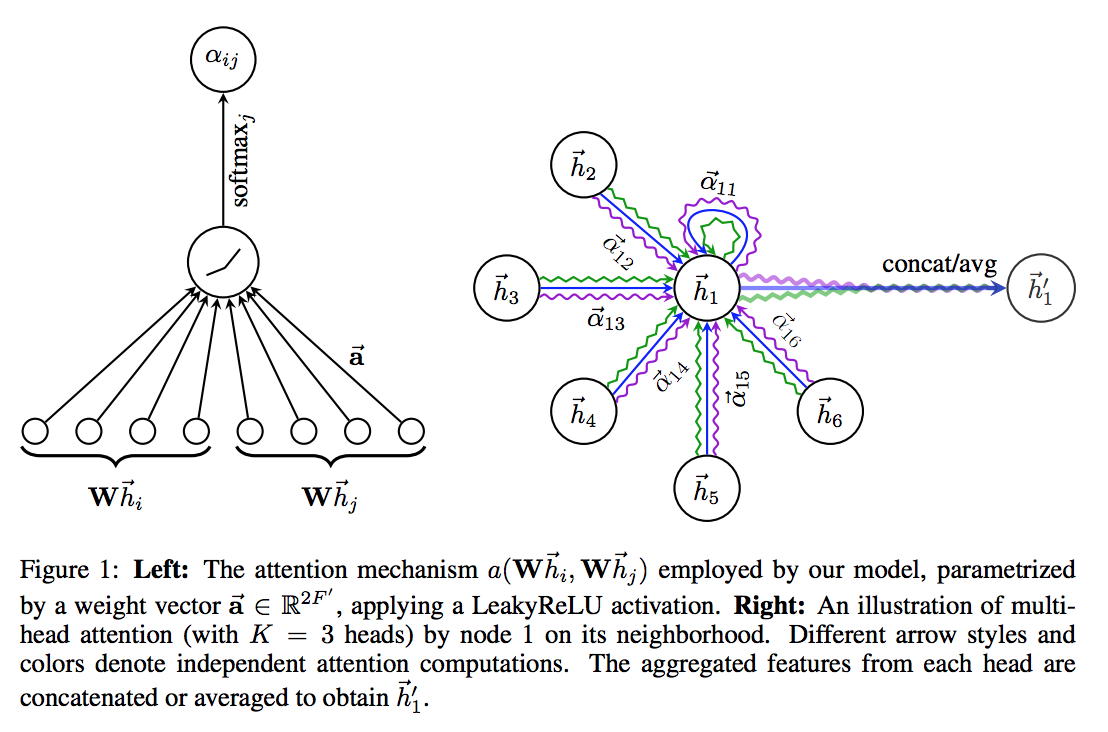

In [1]:
import tensorflow as tf
from IPython.display import Image

Image('../figures/gat_attention.png')

##### Image source : Velickovic, Petar, et al. "Graph attention networks." arXiv preprint arXiv:1710.10903 (2017).

Let's implement the graph attention network.

In [2]:
def attn_coeffs(_X, _A, _C):
    
    # _X : [batch_size, num_nodes, num_features]
    # _A : [batch_size, num_nodes, num_nodes]
    # C : [num_features, num_features]
    # A : [batch_size, num_nodes, num_nodes]
    # A = activation(_X * C * _X^T)
    
    X1 = tf.transpose(_X, [0,2,1])
    X2 = tf.einsum('ij,ajk->aik', _C, X1)
    attn_matrix = tf.matmul(_X, X2)
    attn_matrix = tf.multiply(_A, attn_matrix)
    attn_matrix = tf.nn.tanh(attn_matrix)
    
    return attn_matrix

In [3]:
def graph_attn(_X, _A, output_dim, num_channels):

    # K-head attention
    states = []
    for k in range(num_channels):
        C_k = tf.get_variable('attn_weight-'+str(k), initializer=tf.contrib.layers.xavier_initializer(), shape=[output_dim, output_dim], dtype=tf.float64)
        X_k = tf.layers.dense(_X, output_dim, use_bias=True)
        attn_matrix = attn_coeffs(X_k, _A, C_k)
        X_k = tf.matmul(attn_matrix, X_k)
        states.append(X_k)
    
    output = tf.reduce_mean(states, 0)
    output = tf.nn.relu(output)
    
    return output

In [4]:
X = tf.placeholder(tf.float64, shape=[None, 50, 58])
A = tf.placeholder(tf.float64, shape=[None, 50, 50])

graph_attn(X, A, 32, 4)

<tf.Tensor 'Relu:0' shape=(?, 50, 32) dtype=float64>

We can implement the attention mechanism easily using 'einstein summation': <br>
https://www.tensorflow.org/api_docs/python/tf/einsum

I finish the introduction and implementation of the graph attention networks. <br>
You can see full implementation of GAT to predict molecular properties at this repository. <br>
In my paper, the GAT shows much better performance than GCN. Refer my paper and Velickovic, Petar, et al.